In [2]:
!nvidia-smi

Sun Jun 27 18:04:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%matplotlib inline
 
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MayaChallenge/
 
!easy_install GDAL
 
# !unzip ./DiscoverMayaChallenge_data.zip -d ./data

Mounted at /content/drive
/content/drive/MyDrive/MayaChallenge
Searching for GDAL
Best match: GDAL 2.2.2
Adding GDAL 2.2.2 to easy-install.pth file

Using /usr/lib/python2.7/dist-packages
Processing dependencies for GDAL
Finished processing dependencies for GDAL


In [4]:
from segmentation_transforms import Compose, RandomHorizontalFlip, RandomCrop, Normalize, RandomResize

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
 
from osgeo import gdal, gdal_array
 
from pathlib import Path
from copy import copy
from torch.utils.data import Dataset, random_split
import torch
from torch import nn
from torchvision import transforms as T
from torch.nn import functional as F
from segmentation_transforms import Compose, RandomHorizontalFlip, RandomCrop, Normalize, RandomResize
import torchvision.transforms.functional as transforms_F
 
import pickle
 
from pathlib import Path
 
from chactun_dataset import ChactunDataset, UpsampleSentinelToLidar
 
mask_train_path = Path('./data/train_masks')
lidar_train_path = Path('./data/lidar_train')
sent1_train_path = Path('./data/Sentinel1_train')

In [6]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

config = DotDict()
# with open('./dataset_stats.pickle', 'rb+') as f:
#     config.mean, config.std = pickle.load(f)
# Здесь мы задаем конечный размер картинки, которую выдает нам датасет и которая подается в модель.
# Если вы делаете предсказания не для соревнования, то поставьте здесь 250, тогда размер выходных масок сегментации будет
# 250х250, как и картинка, которая подавалась на вход. 
# Для соревнования размер 480х480
config.resize_min = 250 # TODO агументации
config.resize_max = 250
config.crop_size = 250
config.pretrained = True
config.num_classes = len(ChactunDataset.classes)
config.batch_size = 4
config.epochs = 10
config.lr = 1e-3
config.momentum = 0.9
config.sentinel1_bands = None
config.sentinel2_bands = None

In [7]:
!ls data/

lidar_test   Sentinel1_test   Sentinel2_test   train_masks
lidar_train  Sentinel1_train  Sentinel2_train


In [8]:
def get_transofrms(h_flip_prob, resize_min, resize_max, crop_size, mean, std):
    train_transform = Compose([        
        UpsampleSentinelToLidar(),
        RandomResize(resize_min, resize_max),
        RandomCrop(crop_size)
    ])
    test_transform = Compose([
        UpsampleSentinelToLidar()
    ])

    return train_transform, test_transform

def get_dataset(config, root='./data', val_size=0.25):
    train_transform, test_transform = get_transofrms(
        config.h_flip_prob,
        config.resize_min,
        config.resize_max,
        config.crop_size,
        config.mean,
        config.std
    )

    ds = ChactunDataset(root, is_train=True, transform=train_transform,
                        sentinel1_bands=config.sentinel1_bands,
                        sentinel2_bands=config.sentinel2_bands)
    train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])

    test_ds = ChactunDataset(root, is_train=False, transform=test_transform,
                             sentinel1_bands=config.sentinel1_bands,
                             sentinel2_bands=config.sentinel2_bands)

    return train_ds, val_ds, test_ds

In [9]:
from torch.utils.data import DataLoader
 
train_ds, val_ds, test_ds = get_dataset(config, './data')
 
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=config.batch_size, drop_last=True)

In [10]:
train_ds[0][0].shape

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([8, 250, 250])

# Модель

В этом эксперименте было обучено 3 модели, которые встраивают дополнительные каналы в разные места сети, при этом сеть дублируется до места разветвления, а затем карты активации сливаются. Выбор точек слияния осуществлялся согласно данной статье:  
https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/


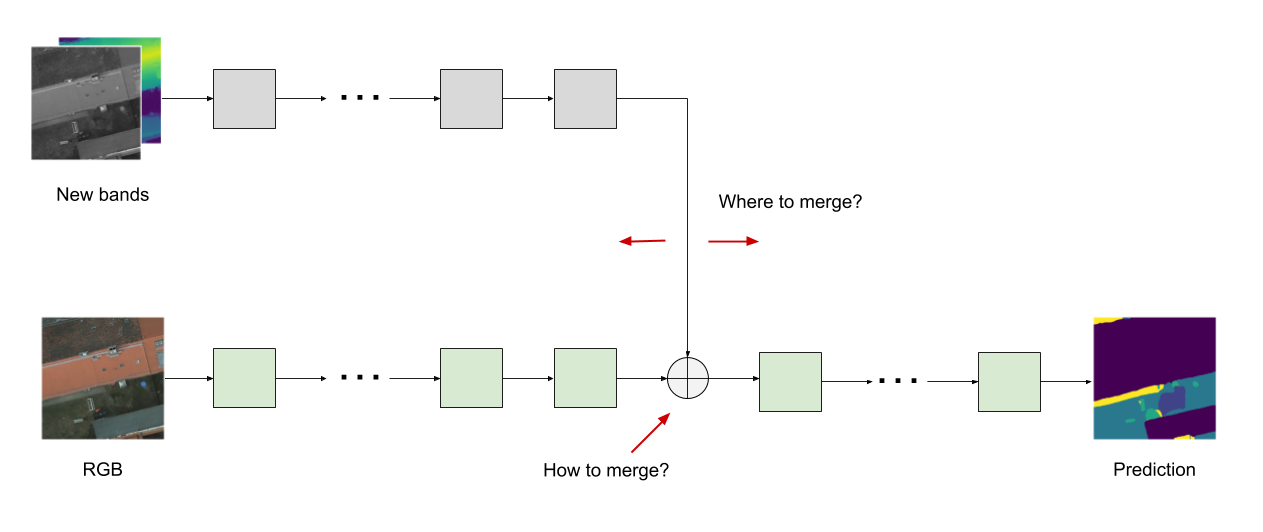

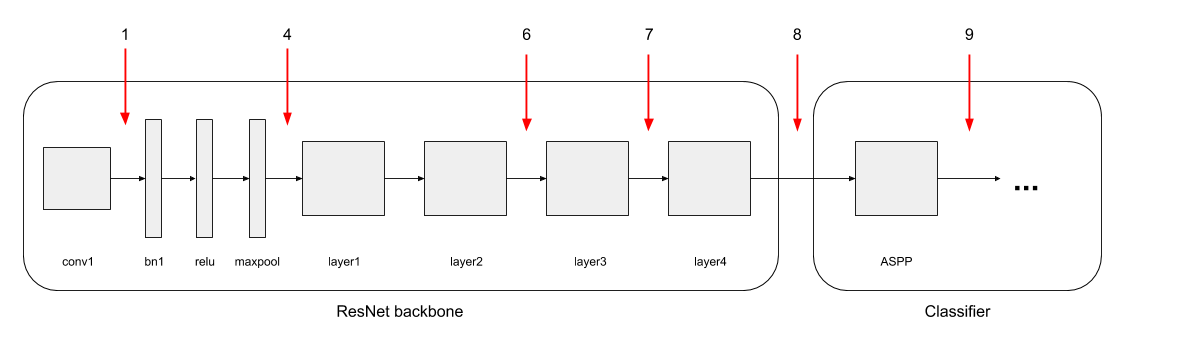

Наиболее простым решением является удвоить backbone. Для слияния карт активации использовалось суммирование, так как согласно статье оно не даёт различий с использованием свёрток 1x1

In [11]:
from collections import OrderedDict
from torchvision import models


class TwinBackbone_DeepLabV3(nn.Module):
    """
    Twin-backbone version of deeplab
    second backbone is provided by ResNet101 pretrained on ImageNet
    and is used for transfer learning 3 additional satteline channels 

    https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/
    https://github.com/pytorch/vision/blob/d9633fc940faabdd73eb61232011a22de9095ca0/torchvision/models/segmentation/_utils.py
    """

    def __init__(self, config):
        super(TwinBackbone_DeepLabV3, self).__init__()
        self.config = config

        lid_deeplab = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True)
        sat_deeplab = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True)

        self.classifier = lid_deeplab.classifier
        self.classifier[4] = nn.Conv2d(256, self.config.num_classes, 1)

        self.lid_backbone = lid_deeplab.backbone
        self.sat_backbone = sat_deeplab.backbone

    def forward(self, x):
        input_shape = x.shape[-2:]

        lid = [0,1,2]
        sat = [3,4,7]

        x = self.lid_backbone(x[:,lid,:,:])['out'] + \
            self.sat_backbone(x[:,sat,:,:])['out']

        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        return torch.sigmoid(x)

model = TwinBackbone_DeepLabV3(config)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [12]:
!pip install torchinfo
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                             Param #
TwinBackbone_DeepLabV3                             --
├─DeepLabHead: 1-1                                 --
│    └─ASPP: 2-1                                   --
│    │    └─ModuleList: 3-1                        15,206,912
│    │    └─Sequential: 3-2                        328,192
│    └─Conv2d: 2-2                                 589,824
│    └─BatchNorm2d: 2-3                            512
│    └─ReLU: 2-4                                   --
│    └─Conv2d: 2-5                                 771
├─IntermediateLayerGetter: 1-2                     --
│    └─Conv2d: 2-6                                 9,408
│    └─BatchNorm2d: 2-7                            128
│    └─ReLU: 2-8                                   --
│    └─MaxPool2d: 2-9                              --
│    └─Sequential: 2-10                            --
│    │    └─Bottleneck: 3-3                        75,008
│    │    └─Bottleneck: 3-4                      

In [13]:
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def discretize_segmentation_maps(probs, thresh):
    if thresh is None:
        thresh = [0.5, 0.5, 0.5]
    if isinstance(thresh, int):
        thresh = [thresh] * 3
    thresh = torch.from_numpy(np.array(thresh)).to(probs.device)
    return probs > thresh[:, None, None]

def get_ious(y_pred, y_true, thresh=None, eps=1e-7):
    y_pred = discretize_segmentation_maps(y_pred, thresh).float()
    y_true = y_true.float()
    with torch.no_grad():
        intersection = torch.sum(y_true * y_pred, dim=[2, 3])
        union = torch.sum(y_true, dim=[2, 3]) + torch.sum(y_pred, dim=[2, 3]) - intersection
        ious = ((intersection + + eps) / (union + eps)).mean(dim=0)
    return ious

In [ ]:
!pip install wandb
 
import wandb
wandb.init(config=config)
wandb.watch(model, log_freq=100)

In [16]:
from tqdm.notebook import tqdm, trange

def train(model):
    crit = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum)
    sched = optim.lr_scheduler.OneCycleLR(optimizer, config.lr, 
                                        epochs=config.epochs, 
                                        steps_per_epoch=len(train_dl))
    for i in trange(config.epochs):
        model.train()
        for X, y in tqdm(train_dl):
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(X)
            loss = crit(pred, y)
            loss.backward()
            optimizer.step()
            sched.step()
            
            #LOG metrics to wandb
            ious = get_ious(pred, y, config.prediction_thresh).cpu()
            metrics = {'iou_' + class_name: iou_score.item()
                    for class_name, iou_score in zip(ChactunDataset.classes, ious)}
            metrics['avg_iou'] = ious.mean()
            metrics['loss'] = loss.item()
            metrics['lr'] = sched.get_last_lr()
            wandb.log(metrics)

        model.eval()
        losses = []
        ious = []
        for X, y in val_dl:
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                pred = model(X)
                losses.append(crit(pred, y).item())
                iou = get_ious(pred, y, config.prediction_thresh)
                ious.append(iou.cpu().numpy())
        metrics = {'val_iou_' + class_name: iou_score.item()
                    for class_name, iou_score in zip(ChactunDataset.classes, np.stack(ious).mean(axis=0))}
        metrics['val_avg_iou'] = np.array(ious).mean(axis=0).mean()
        metrics['val_loss'] = np.mean(losses)
        wandb.log(metrics)

In [17]:
model = model.to(device)
train(model)
model = model.cpu()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
torch.save(model.state_dict(), 'model_twin_backbone-50.pth')

In [ ]:
wandb.run.finish()

### Встроимся после второго слоя

In [20]:
from collections import OrderedDict
from torchvision import models

class TwinL2_DeepLabV3(nn.Module):
    """
    Early intercalation into deeplab backbone.
    Intercalation after backbone.layer2

    https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/
    https://github.com/pytorch/vision/blob/d9633fc940faabdd73eb61232011a22de9095ca0/torchvision/models/segmentation/_utils.py
    """

    def __init__(self, config):
        super(TwinL2_DeepLabV3, self).__init__()
        self.config = config

        lid_deeplab = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True)
        sat_deeplab = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True)

        self.classifier = lid_deeplab.classifier
        self.classifier[4] = nn.Conv2d(256, self.config.num_classes, 1)

        sat_backbone = sat_deeplab.backbone
        lid_backbone = lid_deeplab.backbone

        self.lid_backbone_1_2 = nn.Sequential(
            lid_backbone.conv1,
            lid_backbone.bn1,
            lid_backbone.relu,
            lid_backbone.maxpool,
            lid_backbone.layer1,
            lid_backbone.layer2
        )

        self.lid_backbone_3_4 = nn.Sequential(
            lid_backbone.layer3,
            lid_backbone.layer4
        )

        self.sat_backbone = nn.Sequential(
            sat_backbone.conv1,
            sat_backbone.bn1,
            sat_backbone.relu,
            sat_backbone.maxpool,
            sat_backbone.layer1,
            sat_backbone.layer2
        )
        

    def forward(self, x):
        input_shape = x.shape[-2:]

        lid = [0,1,2]
        sat = [3,4,7]

        x = self.lid_backbone_1_2(x[:,lid,:,:]) + \
            self.sat_backbone(x[:,sat,:,:])

        x = self.lid_backbone_3_4(x)

        x = self.classifier(x)
        
        # from pytorch DeepLabV3 source https://github.com/pytorch/vision/blob/d9633fc940faabdd73eb61232011a22de9095ca0/torchvision/models/segmentation/_utils.py
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        return torch.sigmoid(x)

model = TwinL2_DeepLabV3(config)

In [21]:
summary(model)

Layer (type:depth-idx)                             Param #
TwinL2_DeepLabV3                                   --
├─DeepLabHead: 1-1                                 --
│    └─ASPP: 2-1                                   --
│    │    └─ModuleList: 3-1                        15,206,912
│    │    └─Sequential: 3-2                        328,192
│    └─Conv2d: 2-2                                 589,824
│    └─BatchNorm2d: 2-3                            512
│    └─ReLU: 2-4                                   --
│    └─Conv2d: 2-5                                 771
├─Sequential: 1-2                                  --
│    └─Conv2d: 2-6                                 9,408
│    └─BatchNorm2d: 2-7                            128
│    └─ReLU: 2-8                                   --
│    └─MaxPool2d: 2-9                              --
│    └─Sequential: 2-10                            --
│    │    └─Bottleneck: 3-3                        75,008
│    │    └─Bottleneck: 3-4                      

In [ ]:
model = model.to(device)
wandb.init(config=config)
wandb.watch(model, log_freq=100)

In [23]:
train(model)
model = model.cpu()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [24]:
torch.save(model.state_dict(), 'model_twinl2-52.pth')

In [ ]:
wandb.run.finish()

### Интеркаляция после 3 слоя
В приведённой статье статье интеркаляция после 3 слоя показывала наилучшие результаты, проверим на нашей моделе

In [26]:
from torchvision import models

class TwinL3_DeepLabV3(nn.Module):
    """
    Early intercalation into deeplab backbone.
    Intercalation after backbone.layer3

    https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/
    """

    def __init__(self, config):
        super(TwinL3_DeepLabV3, self).__init__()
        self.config = config

        lid_deeplab = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True)
        sat_deeplab = models.segmentation.deeplabv3_resnet101(
            pretrained=self.config.pretrained, progress=True)

        self.classifier = lid_deeplab.classifier
        self.classifier[4] = nn.Conv2d(256, self.config.num_classes, 1)

        sat_backbone = sat_deeplab.backbone
        lid_backbone = lid_deeplab.backbone

        self.lid_backbone_1_3 = nn.Sequential(
            lid_backbone.conv1,
            lid_backbone.bn1,
            lid_backbone.relu,
            lid_backbone.maxpool,
            lid_backbone.layer1,
            lid_backbone.layer2,
            lid_backbone.layer3
        )

        self.lid_backbone_4 = lid_backbone.layer4

        self.sat_backbone = nn.Sequential(
            sat_backbone.conv1,
            sat_backbone.bn1,
            sat_backbone.relu,
            sat_backbone.maxpool,
            sat_backbone.layer1,
            sat_backbone.layer2,
            sat_backbone.layer3
        )
        

    def forward(self, x):
        input_shape = x.shape[-2:]

        lid = [0,1,2]
        sat = [3,4,7]

        x = self.lid_backbone_1_3(x[:,lid,:,:]) + \
            self.sat_backbone(x[:,sat,:,:])

        x = self.lid_backbone_4(x)

        x = self.classifier(x)

        # from pytorch DeepLabV3 source https://github.com/pytorch/vision/blob/d9633fc940faabdd73eb61232011a22de9095ca0/torchvision/models/segmentation/_utils.py
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)

        return torch.sigmoid(x)

model = TwinL3_DeepLabV3(config)

In [27]:
summary(model)

Layer (type:depth-idx)                             Param #
TwinL3_DeepLabV3                                   --
├─DeepLabHead: 1-1                                 --
│    └─ASPP: 2-1                                   --
│    │    └─ModuleList: 3-1                        15,206,912
│    │    └─Sequential: 3-2                        328,192
│    └─Conv2d: 2-2                                 589,824
│    └─BatchNorm2d: 2-3                            512
│    └─ReLU: 2-4                                   --
│    └─Conv2d: 2-5                                 771
├─Sequential: 1-2                                  --
│    └─Conv2d: 2-6                                 9,408
│    └─BatchNorm2d: 2-7                            128
│    └─ReLU: 2-8                                   --
│    └─MaxPool2d: 2-9                              --
│    └─Sequential: 2-10                            --
│    │    └─Bottleneck: 3-3                        75,008
│    │    └─Bottleneck: 3-4                      

In [ ]:
model = model.to(device)
wandb.init(config=config)
wandb.watch(model, log_freq=100)

In [29]:
train(model)
model = model.cpu()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [36]:
torch.save(model.state_dict(), 'model_twinl3-53-a.pth')

In [ ]:
wandb.run.finish()